# **Stochastic MABs**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### The first thing to do is to code a simulator (or environment) to run a Multi-Armed Bandit Trial. For simplicity, we start with the most simple probability distribution, Bernoulli. Thus, rewards will be $r_t \in \{0,1\}$.

In [2]:
class Environment:
    def __init__(self):
        pass

    def round(self, a_t):
        pass

In [3]:
class BernoulliEnvironment(Environment):
    def __init__(self, p, T, seed):
        np.random.seed(seed)
        self.K = len(p)
        self.rewards = np.random.binomial(n=1, p=p, size=(T, self.K))
        self.t = 0

    def round(self, a_t):
        r_t = self.rewards[self.t, a_t]
        self.t +=1
        return r_t

In [4]:
p = np.array([0.25, 0.5, 0.75])
K = len(p)
T = 100
seed = 17

env = BernoulliEnvironment(p, T, seed)
env.round(0)

0

In [5]:
env.t, env.round(2), env.t

(1, 1, 2)

### How can I interact with this environment? We use Agents

In [6]:
# this is the blueprint of an Agent-type class, we can customize this with our strategy
class Agent:
    def __init__(self):
        pass
    def pull_arm(self):
        pass
    def update(self, r_t):
        pass

In [7]:
class RandomAgent(Agent):
    def __init__(self, K, T, seed):
        np.random.seed(seed)
        self.actions_sequence = np.random.choice(np.arange(K), size=T)
        self.a_t = None
        self.action_history = np.array([])
        self.t = 0
    def pull_arm(self):
        self.a_t = self.actions_sequence[self.t]
        return self.a_t
    def update(self, r_t):
        self.action_history = np.append(self.action_history, self.a_t)
        self.t += 1

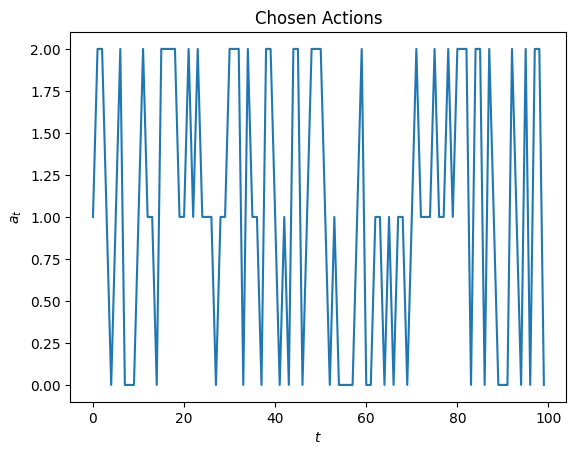

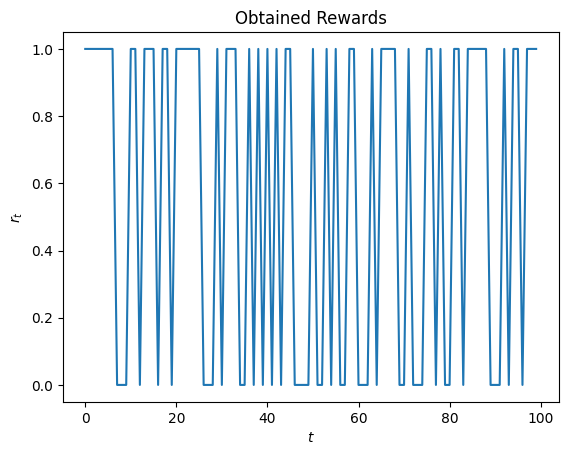

In [8]:
env = BernoulliEnvironment(p, T, seed)
rand_agent = RandomAgent(K, T, seed)

rewards = np.array([])
action_sequence = np.array([])
for t in range(T):
    a_t = rand_agent.pull_arm()
    r_t = env.round(a_t)
    rand_agent.update(r_t) # doesn't do anything
    #logging
    rewards = np.append(rewards, r_t)
    action_sequence = np.append(action_sequence, a_t)

plt.plot(action_sequence)
plt.xlabel('$t$')
plt.ylabel('$a_t$')
plt.title('Chosen Actions')
plt.show()

plt.plot(rewards)
plt.xlabel('$t$')
plt.ylabel('$r_t$')
plt.title('Obtained Rewards')
plt.show()

## **The Notion of Regret**

### What is the best action sequence?

In [9]:
best_action = np.argmax(p)
print(f'Best action is {best_action}')

Best action is 2


### The total _expected_ reward of always playing the best action $a^*$ is $T \mu (a^*) = \sum_{t=1}^T \mathbb{E} [r_t(a^*)] = \mathbb{E} [\sum_{t=1}^T r_t(a^*)]$

In [10]:
expected_clairvoyant_rewards = np.repeat(p[best_action], T)

sum(expected_clairvoyant_rewards)

75.0

### However, a clairvoyant doesn't actually gain $T\mu(a^*)$, but $\sum_{t=1}^T r_t(a^*)$, this is the actual clairvoyant's reward (and it's random due to the nature of the environment)

In [11]:
clairvoyant_rewards = env.rewards[:, best_action]

sum(clairvoyant_rewards) 

77

### Pseudo Regret express how bad my actions are, _in expectation_, w.r.t. a clairvoyant, i.e. $R_T = \mathbb{E}[\sum_{t=1}^T r_t(a^*)-r_t(a_t)] = T\mu(a^*) - \sum_{t=1}^T \mathbb{E}[r_t(a_t)] = \sum_{t=1}^T \Delta_{a_t}$, instead, the actual regret is computed on the rewards observed (including the environment's noise).

In [12]:
expected_agent_rewards = np.repeat(p.sum()/len(p), T)

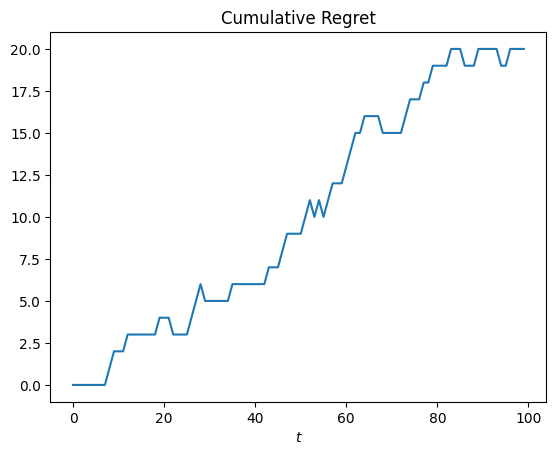

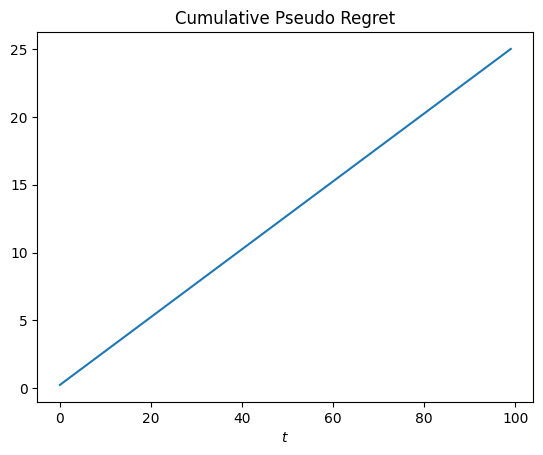

In [13]:
instantaneous_regret = clairvoyant_rewards - rewards
instantaneous_pseudo_regret = expected_clairvoyant_rewards - expected_agent_rewards

cumulative_regret = np.cumsum(instantaneous_regret)
plt.plot(cumulative_regret)
plt.xlabel('$t$')
plt.title('Cumulative Regret')
plt.show()

cumulative_pseudo_regret = np.cumsum(instantaneous_pseudo_regret)
plt.plot(cumulative_pseudo_regret)
plt.xlabel('$t$')
plt.title('Cumulative Pseudo Regret')
plt.show()

### For a random agent is easy to compute the expected cumulative reward, and thus to obtain the cumulative pseudo-regret in a closed form. However, for more complex agents is usually impossible to obtain the true expectation on their rewards.

### In practice, after a bandit trial you usually observe only the first plot. But the more interesting is the second one. 

### So we can proceed by trying the agent on multiple different simulations, and empirically estimate its pseudo-regret as the average of all the regrets attained during the trials.

### We need multiple trials to estimate it:

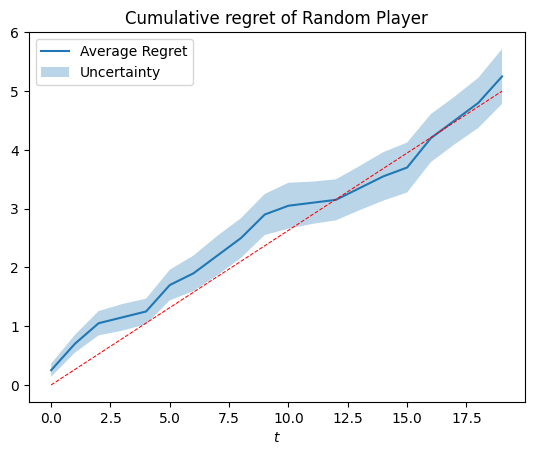

In [15]:
p = np.array([0.25, 0.5, 0.75])
T = 20
expected_clairvoyant_rewards = np.repeat(p[best_action], T) # this remains the same after every trial

n_trials = 20

regret_per_trial = []

for seed in range(n_trials):
    np.random.seed(seed)
    env = BernoulliEnvironment(p, T, seed)
    rand_agent = RandomAgent(K, T, seed)

    agent_rewards = np.array([])

    for t in range(T):
        a_t = rand_agent.pull_arm()
        r_t = env.round(a_t)
        rand_agent.update(r_t)

        agent_rewards = np.append(agent_rewards, r_t)

    cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('Cumulative regret of Random Player')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.plot((0,T-1), (0, T*(max(p)-p.sum()/len(p))), 'r', linestyle="--", linewidth=0.75)
plt.xlabel('$t$')
plt.legend()
plt.show()

### We approximated pseudo-regret starting from regrets coming from multiple trials. We also quantified the uncertainty around this estimation.

### **MAIN GOAL IN BANDITS**: Obtain Sub-Linear Regret

### We have to deal with the exploration-exploitation trade-off, but do we really need exploration?

In [16]:
## Exercise: produce a code showing that a greedy strategy suffers a linear expected regret in certain instances
## Hint: code the GreedyAgent class and a new Environment-type class on which to test it

## **The Explore-Then-Commit (ETC) Algorithm**

In [17]:
class ETCAgent(Agent):
    def __init__(self, K, T, T0):
        self.K = K 
        self.T = T
        self.T0 = T0
        self.a_t = None
        self.average_rewards = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.t = 0
    
    def pull_arm(self):
        if self.t <= self.K*self.T0:
            self.a_t = self.t % self.K
        else:
            self.a_t = np.argmax(self.average_rewards)
        return self.a_t
    
    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.average_rewards[self.a_t] += (r_t - self.average_rewards[self.a_t])/self.N_pulls[self.a_t]
        self.t += 1

### Will it perform better? Let's estimate the pseudo-regret:

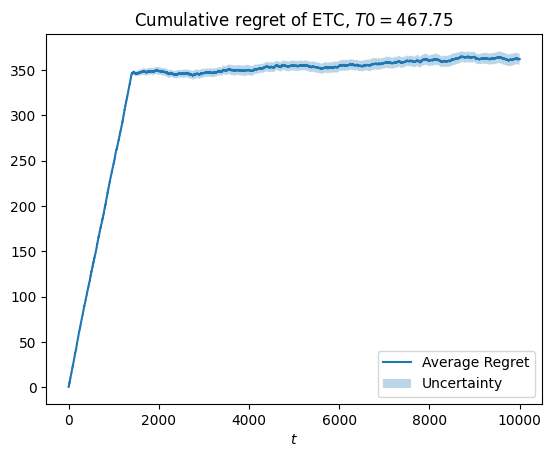

Text(0.5, 1.0, 'number of pulls per arm of ETC')

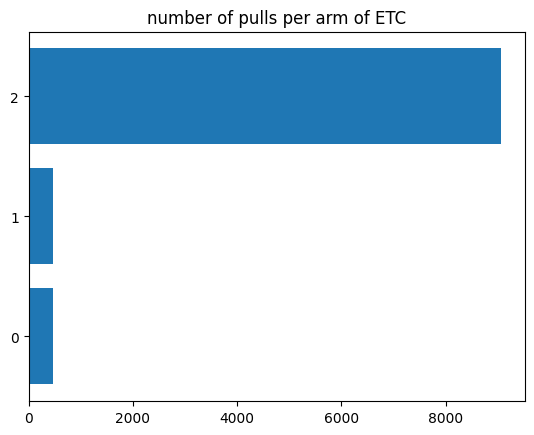

In [18]:
p = np.array([0.25, 0.5, 0.75])
T = 10000

T0 = (T/K)**(2/3)*np.log(T)**(1/3) # we set the exploration length as prescribed by the theory
expected_clairvoyant_rewards = np.repeat(p[best_action], T)

n_trials = 20

regret_per_trial = []

for seed in range(n_trials):
    np.random.seed(seed)
    env = BernoulliEnvironment(p, T, seed)
    etc_agent = ETCAgent(K, T, T0=T0)

    agent_rewards = np.array([])

    for t in range(T):
        a_t = etc_agent.pull_arm()
        r_t = env.round(a_t)
        etc_agent.update(r_t)

        agent_rewards = np.append(agent_rewards, r_t)

    cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title(f'Cumulative regret of ETC, $T0={round(T0,2)}$')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
#plt.plot((0,T-1), (average_regret[0], average_regret[-1]), 'ro', linestyle="--")
plt.xlabel('$t$')
plt.legend()
plt.show()

plt.barh(y=['0','1','2'], width=etc_agent.N_pulls)
plt.title('number of pulls per arm of ETC')

### Can we do even better?

## **The UCB1 Algorithm**

In [19]:
class UCB1Agent(Agent):
    def __init__(self, K, T, range=1):
        self.K = K
        self.T = T
        self.range = range
        self.a_t = None
        self.average_rewards = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.t = 0
    
    def pull_arm(self):
        if self.t < self.K:
            self.a_t = self.t 
        else:
            ucbs = self.average_rewards + self.range*np.sqrt(2*np.log(self.T)/self.N_pulls)
            self.a_t = np.argmax(ucbs)
        return self.a_t
    
    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.average_rewards[self.a_t] += (r_t - self.average_rewards[self.a_t])/self.N_pulls[self.a_t]
        self.t += 1

### Will it perform better? Let's estimate the pseudo-regret:

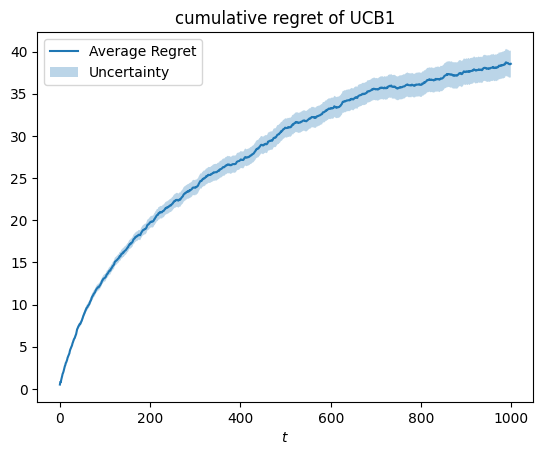

Text(0.5, 1.0, 'number of pulls per arm of UCB1')

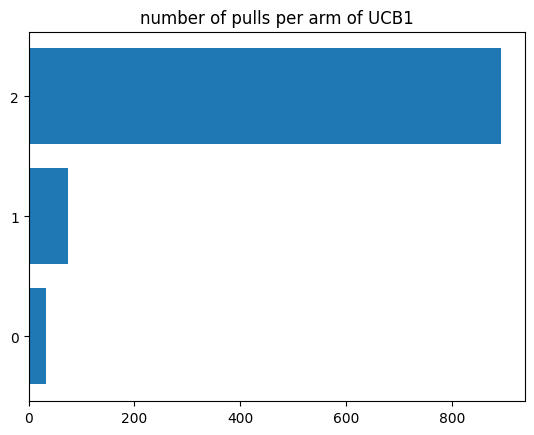

In [40]:
p = np.array([0.25, 0.5, 0.75])
T = 1000
expected_clairvoyant_rewards = np.repeat(p[best_action], T)

n_trials = 100

regret_per_trial = []

for seed in range(n_trials):
    np.random.seed(seed)
    env = BernoulliEnvironment(p, T, seed)
    ucb_agent = UCB1Agent(K, T)

    agent_rewards = np.array([])

    for t in range(T):
        a_t = ucb_agent.pull_arm()
        r_t = env.round(a_t)
        ucb_agent.update(r_t)

        agent_rewards = np.append(agent_rewards, r_t)

    cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of UCB1')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
#plt.plot((0,T-1), (average_regret[0], average_regret[-1]), 'ro', linestyle="--")
plt.xlabel('$t$')
plt.legend()
plt.show()

plt.barh(y=['0','1','2'], width=ucb_agent.N_pulls)
plt.title('number of pulls per arm of UCB1')

### What happens if the rewards are not in [0,1]?

In [21]:
### Exercise: repeat the previous experiments with an environment generating rewards in [0, 10], and try to make UCB1 work properly
### Hint: Try to use a Binomial instead of a Bernoulli

### How can I improve UCB1 and avoid providing T as an input?

In [22]:
### Exercise: slightly modify the UCB1Agent to work without requiring T as an input, show that the empirical performances improve

### Visual representation of confidence intervals shrinking

/var/folders/4h/m7h4lrd53d15wcxksyytrdqh0000gn/T/ipykernel_70702/1544935275.py:23: RuntimeWarning: divide by zero encountered in divide
  ci_widths[t,:] = np.sqrt(2*np.log(T)/n_pulls)


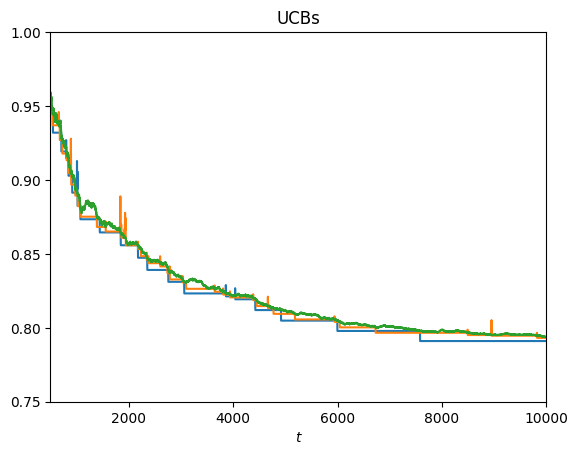

In [23]:
import sys 

p = np.array([0.25, 0.5, 0.75])
sigma = 0.1
T = 10000

env = BernoulliEnvironment(p, T, seed)
ucb_agent = UCB1Agent(K, T)
n_pulls = np.zeros(K)

ci_widths = np.zeros((T,K))

curr_widths = np.sqrt(2*np.log(T))
curr_average = np.zeros((T,K))

for t in range(T):
    a_t = ucb_agent.pull_arm()
    r_t = env.round(a_t)
    ucb_agent.update(r_t)

    n_pulls[a_t] += 1

    ci_widths[t,:] = np.sqrt(2*np.log(T)/n_pulls)

    curr_average[t,:] = curr_average[t-1,:]
    curr_average[t,a_t] += (r_t - curr_average[t,a_t])/n_pulls[a_t]

plt.plot(curr_average+ci_widths)
plt.title('UCBs')
plt.xlabel('$t$')
plt.ylim(0.75,1)
plt.xlim(500, 10000)
plt.show()

## **The Thompson Sampling Algorithm**

In [24]:
p = np.array([0.25, 0.5, 0.75])
K = 3
T = 100
seed = 17

env = BernoulliEnvironment(p, T, seed)
env.t, env.round(0), env.t

(0, 0, 1)

### UCB1 is a deterministic algorithm, i.e., given the same sequence of rewards the chosen actions will always be the same. It has been observed that often, in practice, randomized algorithm can perform better.

### We thus introduce Thompson Sampling, an algorithm having similar theoretical guarantees of UCB1, but taking randomized decisions.

In [25]:
class TSAgent(Agent):
    def __init__(self, K):
        self.K = K
        self.a_t = None
        self.alpha, self.beta = np.ones(K), np.ones(K)
        self.N_pulls = np.zeros(K)

    def pull_arm(self):
        theta = np.random.beta(self.alpha, self.beta)
        self.a_t = np.argmax(theta)
        return self.a_t
    
    def update(self, r_t):
        self.alpha[self.a_t] += r_t
        self.beta[self.a_t] += 1-r_t
        self.N_pulls[self.a_t] += 1

### We estimate the pseudo-regret:

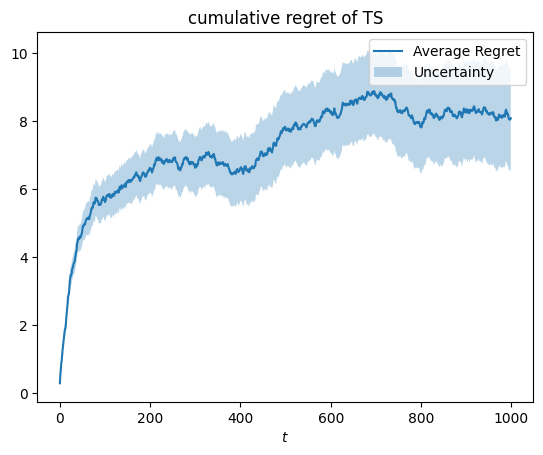

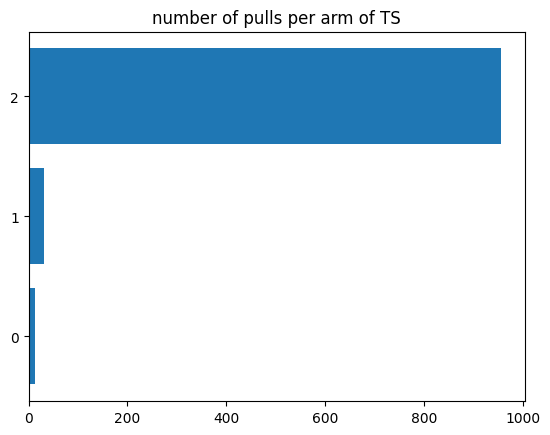

In [39]:
p = np.array([0.25, 0.5, 0.75])
K = len(p)
T = 1000
expected_clairvoyant_rewards = np.repeat(p[best_action], T)

n_trials = 100

regret_per_trial = []

for seed in range(n_trials):
    np.random.seed(seed)
    env = BernoulliEnvironment(p, T, seed)
    ts_agent = TSAgent(K)

    agent_rewards = np.array([])

    for t in range(T):
        a_t = ts_agent.pull_arm()
        r_t = env.round(a_t)
        ts_agent.update(r_t)

        agent_rewards = np.append(agent_rewards, r_t)

    cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of TS')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
#plt.plot((0,T-1), (average_regret[0], average_regret[-1]), 'ro', linestyle="--")
plt.xlabel('$t$')
plt.legend()
plt.show()

plt.barh(y=['0','1','2'], width=ts_agent.N_pulls)
plt.title('number of pulls per arm of TS')
plt.show()

In [32]:
ts_agent.N_pulls

array([9.000e+00, 2.500e+01, 9.966e+03])

## UCB1 vs Thompson Sampling

### Let's compare UCB1 and TS

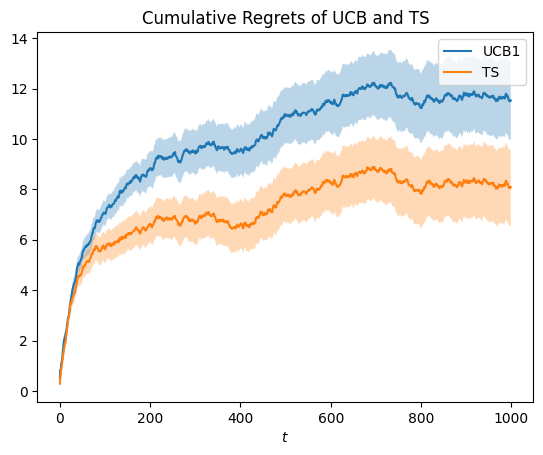

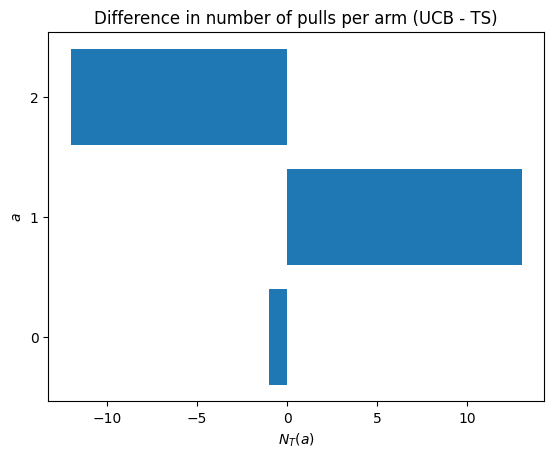

In [41]:
p = np.array([0.25, 0.5, 0.75])
K = len(p)
T = 1000
expected_clairvoyant_rewards = np.repeat(p[best_action], T)

n_trials = 100

ucb_regret_per_trial = []
ts_regret_per_trial = []

for seed in range(n_trials):
    np.random.seed(seed)
    env = BernoulliEnvironment(p, T, seed)
    ucb_agent = UCB1Agent(K, T, range=max(p)-min(p))

    agent_rewards = np.array([])

    for t in range(T):
        a_t = ucb_agent.pull_arm()
        r_t = env.round(a_t)
        ucb_agent.update(r_t)

        agent_rewards = np.append(agent_rewards, r_t)

    cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
    ucb_regret_per_trial.append(cumulative_regret)

    np.random.seed(seed)
    env = BernoulliEnvironment(p, T, seed)
    ts_agent = TSAgent(K)

    agent_rewards = np.array([])

    for t in range(T):
        a_t = ts_agent.pull_arm()
        r_t = env.round(a_t)
        ts_agent.update(r_t)

        agent_rewards = np.append(agent_rewards, r_t)

    cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
    ts_regret_per_trial.append(cumulative_regret)

ucb_regret_per_trial = np.array(ucb_regret_per_trial)
ts_regret_per_trial = np.array(ts_regret_per_trial)

ucb_average_regret = ucb_regret_per_trial.mean(axis=0)
ucb_regret_sd = ucb_regret_per_trial.std(axis=0)

ts_average_regret = ts_regret_per_trial.mean(axis=0)
ts_regret_sd = ts_regret_per_trial.std(axis=0)

plt.plot(np.arange(T), ucb_average_regret, label='UCB1')
plt.plot(np.arange(T), ts_average_regret, label='TS')
plt.title('Cumulative Regrets of UCB and TS')
plt.fill_between(np.arange(T),
                ucb_average_regret-ucb_regret_sd/np.sqrt(n_trials),
                ucb_average_regret+ucb_regret_sd/np.sqrt(n_trials),
                alpha=0.3)
plt.fill_between(np.arange(T),
                ts_average_regret-ts_regret_sd/np.sqrt(n_trials),
                ts_average_regret+ts_regret_sd/np.sqrt(n_trials),
                alpha=0.3)
plt.xlabel('$t$')
plt.legend()
plt.show()

plt.barh(y=['0','1','2'], width=ucb_agent.N_pulls-ts_agent.N_pulls)
plt.title('Difference in number of pulls per arm (UCB - TS)')
plt.ylabel('$a$')
plt.xlabel('$N_T(a)$')
plt.show()


### Remark: theoretical guarantees of UCB1 and TS are nearly the same. Moreover, TS theoretical guarantees can be proven by showing that this strategy implicitly does optimism, thus the underlying principles of the two algorithms are the same.

### Remark: TS can be used in any stochastic environment, however to move from Bernoulli distributed rewards to more general ones the algorithm needs some non-trivial adjustments. A good reference on coding TS for Gaussian rewards can be found here: https://gertjanvandenburg.com/blog/thompson_sampling/.

In [29]:
### Exercise: try to compare UCB1 and TS in a GaussianEnvironment